In [1]:
import itertools
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir(os.pardir)
import time

import jax
import jax.numpy as jnp
import jax.nn as nn
from jax import random, vmap, jit, grad
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from scipy.special import roots_legendre
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import trange

from src.field import efield, hfield, poynting, poynting_parallel
from src.utils.dataloader import (load_antenna_el_properties,
                                  load_sphere_coords)
from src.utils.derive import holoborodko

In [2]:
# jax.config.update("jax_enable_x64", True)

In [3]:
seaborn.set(style='whitegrid', context='paper', palette='colorblind', font='serif', font_scale=1)

In [4]:
%config InlineBackend.figure_format = 'retina'

# Head model

In [5]:
data = load_sphere_coords(2312)  # spherical head model coordinates

target_area = (2 / 100, 2 / 100)  # effective irradiated surface area
A = target_area[0] * target_area[1]  # area of the effective irradiated surface
d = -5 / 1000  # distance from the antenna

target_area_origin = (-target_area[0]/2, -target_area[1]/2)

data_target = data[  # effective irradiated skin surface
    (data['y'] < 0) &
    (data['x'] > target_area_origin[0]) &
    (data['x'] < target_area_origin[0] * -1) &
    (data['z'] > target_area_origin[1]) &
    (data['z'] < target_area_origin[1] * -1)]
data_target.reset_index(drop=True, inplace=True)
data_target.head()

,x,y,z
0,-0.009562,-0.088281,0.009294
1,0.009562,-0.088281,-0.009294
2,0.009294,-0.088281,0.009562
3,-0.009294,-0.088281,-0.009562
4,-0.008688,-0.088457,0.008554


In [6]:
# coordinates

X = data_target[['x', 'z']].to_numpy()
y = data_target['y'].to_numpy()

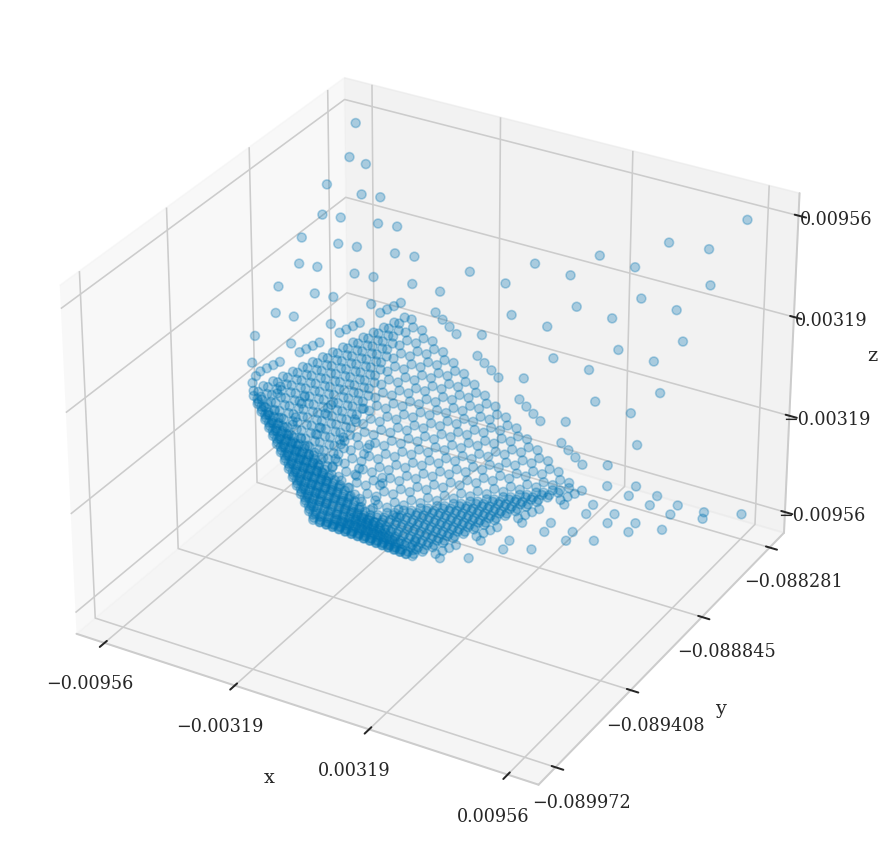

In [7]:
# visualize the observed irradiated skin surface

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X[:, 0], y, X[:, 1], alpha=0.3)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=jnp.mgrid[X[:, 0].min():X[:, 0].max():4j], 
       yticks=jnp.mgrid[y.min():y.max():4j],
       zticks=jnp.mgrid[X[:, 1].min():X[:, 1].max():4j])
plt.tight_layout();

In [8]:
# generating new coordinates withing a given boundaries

def cart2sph(x, y, z):
    """Return spherical given Cartesain coordinates."""
    r = jnp.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = jnp.arccos(z / r)
    phi = jnp.arctan2(y, x)
    return r, theta, phi


def sph2cart(r, theta, phi):
    """Return Cartesian given Spherical coordinates."""
    x = r * jnp.cos(phi) * jnp.sin(theta)
    y = r * jnp.sin(phi) * jnp.sin(theta)
    z = r * jnp.cos(theta)
    return x, y, z


# generate Gaussian points in spherical c.s. and convert to Cartesian c.s.
_, theta, phi = cart2sph(X[:, 0], y, X[:, 1])
theta_a = theta.min()
theta_b = theta.max()
phi_a = phi.min()
phi_b = phi.max()
theta_points, theta_weights = roots_legendre(21)
phi_points, phi_weights = roots_legendre(21)
theta_points = 0.5 * (theta_points + 1.) * (theta_b - theta_a) + theta_a
theta_weights = 0.5 * theta_weights * (theta_b - theta_a)
phi_points = 0.5 * (phi_points + 1.) * (phi_b - phi_a) + phi_a
phi_weights = 0.5 * phi_weights * (phi_b - phi_a)

r = 0.09
phi_grid, theta_grid = jnp.meshgrid(phi_points, theta_points)
xt, yt, zt = sph2cart(r, theta_grid.ravel(), phi_grid.ravel())

In [9]:
# new coordinates

X = jnp.hstack((xt.reshape(-1, 1), zt.reshape(-1, 1)))
y = jnp.array(yt).reshape(-1, 1)

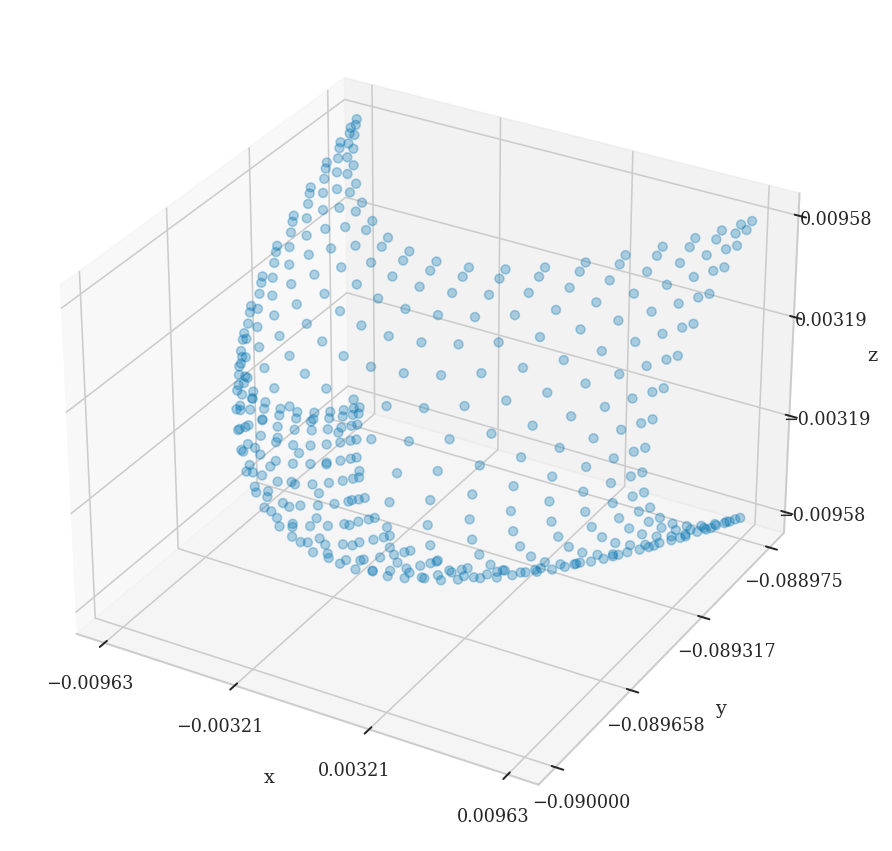

In [10]:
# visualize the observed irradiated skin surface

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X[:, 0], y, X[:, 1], alpha=0.3)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=jnp.mgrid[X[:, 0].min():X[:, 0].max():4j], 
       yticks=jnp.mgrid[y.min():y.max():4j],
       zticks=jnp.mgrid[X[:, 1].min():X[:, 1].max():4j])
plt.tight_layout();

# Antenna model

In [11]:
# antenna electric properties (Poljak 2005)

f = 10e9  # operating frequency

antenna_data = load_antenna_el_properties(f)

Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
Is = jnp.asarray(Is)
xs = antenna_data.x.to_numpy()
xs = jnp.asarray(xs) - xs.max() / 2
ys = jnp.zeros_like(xs) + data_target['y'].min() + d
zs = jnp.zeros_like(xs)

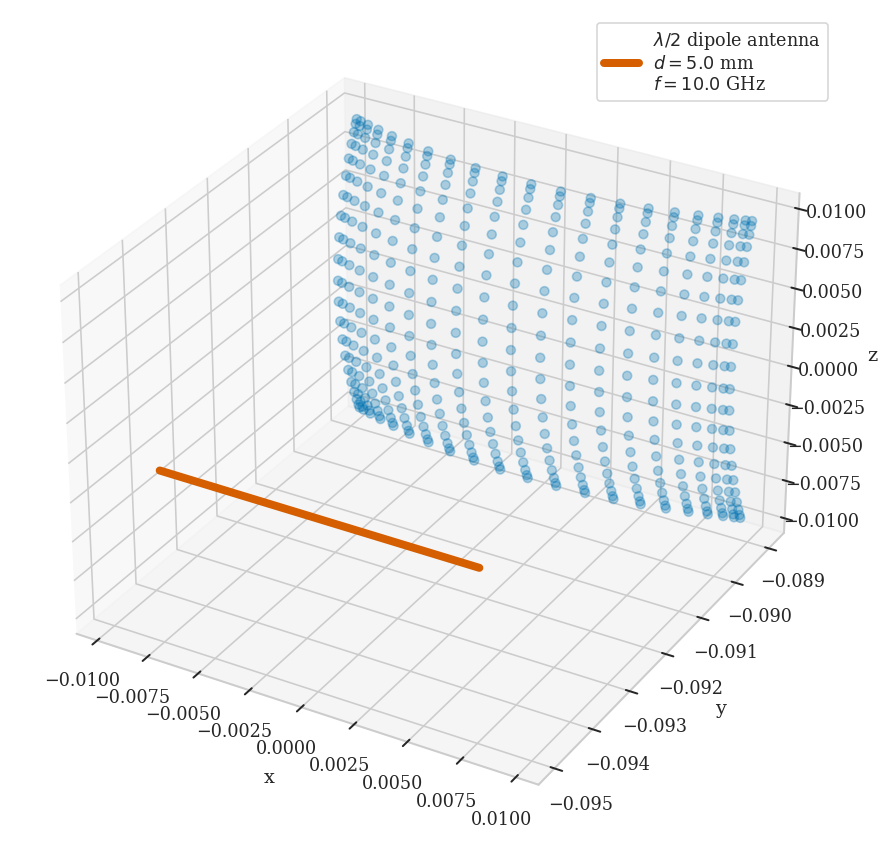

In [12]:
# visualize the antenna position w.r.t. the surface of the head

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X[:, 0], y, X[:, 1], alpha=0.3)
ax.plot(xs, ys, zs, lw=4, linestyle='-', c='r',
        label=(f'$\\lambda/2$ dipole antenna\n'
               f'$d = {-d * 1000}$ mm\n'
               f'$f = {f / 1e9}$ GHz'))
ax.set(xlabel='x', ylabel='y', zlabel='z');
ax.legend()
plt.tight_layout();

# Incident power density

In [16]:
# spatial distribution of current derivative

dx = xs[1] - xs[0]
Is_x = holoborodko(Is, dx)

In [17]:
# compute the power density on the surface of the skin

Sx, Sy, Sz = [], [], []
for _xt, _yt, _zt in zip(X[:, 0], y.ravel(), X[:, 1]):
    _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
    Sx.append(_Sx)
    Sy.append(_Sy)
    Sz.append(_Sz)
Sx = jnp.asarray(Sx)
Sy = jnp.asarray(Sy)
Sz = jnp.asarray(Sz)

S = jnp.sqrt(Sx ** 2 + Sy ** 2 + Sz ** 2)

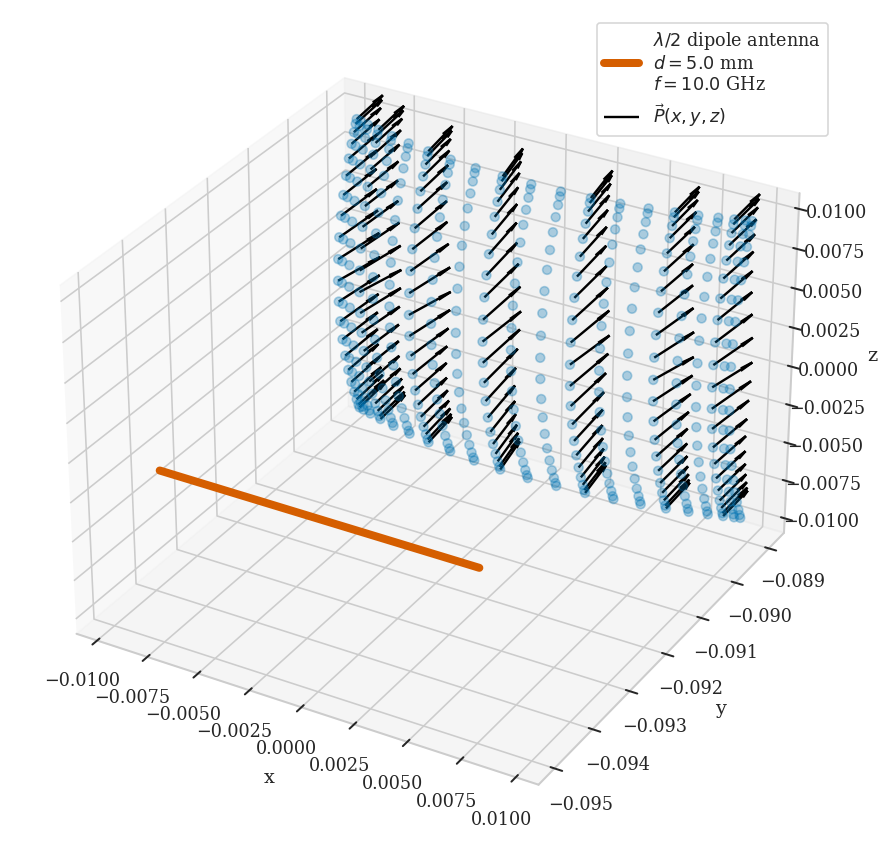

In [18]:
# visualize the power density on the surface of the skin

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.plot(xs, ys, zs, lw=4, linestyle='-', c='r',
        label=(f'$\\lambda/2$ dipole antenna\n'
               f'$d = {-d * 1000}$ mm\n'
               f'$f = {f / 1e9}$ GHz'))
ax.scatter(X[:, 0], y.ravel(), X[:, 1], alpha=0.3)
ax.quiver(X[:, 0][::3], y.ravel()[::3], X[:, 1][::3],
          jnp.abs(Sx[::3]), jnp.abs(Sy[::3]), jnp.abs(Sz[::3]),
          length=0.001, normalize=True, color='black',
          label='$\\vec{P}(x, y, z)$')
ax.set(xlabel='x', ylabel='y', zlabel='z')
ax.legend()
plt.tight_layout();

In [19]:
# incident power density

poynting_mag = 0
for _theta, _w_theta in zip(theta_points, theta_weights):
    for _phi, _w_phi in zip(phi_points, phi_weights):
        # normal vector components
        nx = r ** 2 * jnp.cos(_phi) * jnp.sin(_theta) ** 2 
        ny = r ** 2 * jnp.sin(_phi) * jnp.sin(_theta) ** 2
        nz = r ** 2 * jnp.cos(_theta) * jnp.sin(_theta)
        # power density vector field
        _xt, _yt, _zt = sph2cart(r, _theta, _phi)
        _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
        # dot product between power density and normal vector
        Fn = _Sx.real * nx + _Sy.real * ny + _Sz.real * nz
        poynting_mag += Fn * _w_theta * _w_phi
Sab = poynting_mag / (2 * A)

In [20]:
print(f'IPD = {Sab:.4f} W/m2')

IPD = 5.8074 W/m2


# Neural network parametrization

In [ ]:
# prepare the data for the training of the neural network for an approximation
# of y-coordinate: y = nn(x, z)

X_scaled = X * 100
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

# convert numpy arrays to jax.numpy arrays
X_train = jnp.asarray(X_train)
X_test = jnp.asarray(X_test)
y_train = jnp.asarray(y_train)
y_test = jnp.asarray(y_test)

In [ ]:
# visualize train and test data

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X_train[:, 0], y_train, X_train[:, 1], c='C0', label='train data', alpha=0.3)
ax.scatter(X_test[:, 0], y_test, X_test[:, 1], c='C1', label='test data', alpha=0.5)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=jnp.mgrid[-1:1:5j], zticks=jnp.mgrid[-1:1:5j])
ax.legend()
plt.tight_layout();

In [ ]:
rng = random.PRNGKey(0)


def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    def random_layer_params(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return (scale * random.normal(w_key, (n, m)),
                scale * random.normal(b_key, (n, )))
    return [random_layer_params(m, n, key)
            for m, n, key in zip(sizes[:-1], sizes[1:], keys)]


def forward(params, X):
    output = X
    for w, b in params[:-1]:
        output = nn.relu(w @ output + b)
    w, b = params[-1]
    output = w @ output + b
    return output


batch_forward = vmap(forward, in_axes=(None, 0))


@jit
def loss_fn(params, batch):
    X, y = batch
    y_pred = batch_forward(params, X)
    return jnp.sum(jnp.square(y_pred - y))


grad_fn = jit(grad(loss_fn))


@jit
def update(step, optim_state, batch):
    params = optim_params(optim_state)
    grads = grad_fn(params, batch)
    optim_state = optim_update(step, grads, optim_state)
    return optim_state


def data_stream(num_train, num_batches):
    rng = npr.RandomState(0)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield X_train[batch_idx], y_train[batch_idx]

In [ ]:
step_size = 0.001
n_epochs = 10000
printout = int(n_epochs / 10.)
batch_size = 256
# momentum_mass = 0.9  # for momentum and adagrad
sizes = [2, 128, 256, 128, 1]

num_train = X_train.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

batches = data_stream(num_train, num_batches)

optim_init, optim_update, optim_params = optimizers.adam(step_size)
init_params = init_network_params(sizes, rng)
optim_state = optim_init(init_params)
itercount = itertools.count()

loss_train, loss_test = [], []
best_params = []
for epoch in trange(n_epochs):
    start_time = time.time()
    for _ in range(num_batches):
        optim_state = update(next(itercount), optim_state, next(batches))
    epoch_time = time.time() - start_time
    
    params = optim_params(optim_state)
    if (epoch == 0) or (epoch % printout == (printout - 1)):
        if epoch == 0:
            print('epoch \t| loss on test set')
            print('----- \t| ----------------')
        loss_train.append(loss_fn(params, (X_train, y_train)))
        best_params.append(params)
        l = loss_fn(params, (X_test, y_test))
        loss_test.append(l)
        print(f'{epoch + 1} \t| {l}')

In [ ]:
plt.plot(jnp.arange(0, n_epochs+1, printout), loss_train, label='train loss')
plt.plot(jnp.arange(0, n_epochs+1, printout), loss_test, label='test loss')
plt.yscale('log')
plt.legend();

In [ ]:
best_params_idx = loss_test.index(min(loss_test))
params = best_params[best_params_idx]

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.plot(y_test.flatten(), 'o', label='test values')
plt.plot(batch_forward(best_params[7], X_test).flatten(), 'x', label='predicted values')
plt.legend()
plt.tight_layout();

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X_scaled[:, 0], y_scaled, X_scaled[:, 1], alpha=0.3, label='ground truth')
ax.scatter(X_scaled[:, 0], batch_forward(params, X_scaled), X_scaled[:, 1], marker='x', alpha=0.3, label='nn representation')
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=jnp.mgrid[-1:1:5j], zticks=jnp.mgrid[-1:1:5j])
ax.legend()
plt.tight_layout();

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X[:, 0], y, X[:, 1], alpha=0.3, label='ground truth')
ax.scatter(X[:, 0], scaler.inverse_transform(batch_forward(params, X_scaled)), X[:, 1], marker='x', alpha=0.3, label='nn representation - rescaled')
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=jnp.mgrid[X[:, 0].min():X[:, 0].max():4j], 
       yticks=jnp.mgrid[y.min():y.max():4j],
       zticks=jnp.mgrid[X[:, 1].min():X[:, 1].max():4j]);
ax.legend()
plt.tight_layout();

In [ ]:
def y_nn(X):
    return forward(params, X * 100)[0]


grad_y_nn = jit(vmap(grad(y_nn)))

In [ ]:
x_a = X[:, 0].min()
x_b = X[:, 0].max()
z_a = X[:, 1].min()
z_b = X[:, 1].max()
x_points, x_weights = roots_legendre(33)
z_points, z_weights = roots_legendre(33)
x_points = 0.5 * (x_points + 1.) * (x_b - x_a) + x_a
x_weights = 0.5 * x_weights * (x_b - x_a)
z_points = 0.5 * (z_points + 1.) * (z_b - z_a) + z_a
z_weights = 0.5 * z_weights * (z_b - z_a)

In [ ]:
poynting_mag = 0
for xt, w_xt in zip(x_points, x_weights):
    for zt, w_zt in zip(z_points, z_weights):
        xtzt = jnp.atleast_2d(jnp.r_[xt, zt])
        yt_scaled = batch_forward(params, xtzt)
        yt = scaler.inverse_transform(yt_scaled)[0][0]
        grad_yt_scaled = grad_y_nn(xtzt)
        grad_yt = scaler.inverse_transform(grad_yt_scaled)
        Sx, Sy, Sz = poynting(xt, yt, zt, xs, ys, zs, f, Is, Is_x)
        # dot product between power density and vector normal to dA (not unit vector)
        Sn = Sx.real * grad_yt[0][0] + Sz.real * grad_yt[0][1] - Sy.real
        poynting_mag += Sn * w_xt * w_zt
Sab = poynting_mag / (2 * A)

In [ ]:
print(f'IPD = {Sab:.4f} W/m2')